In [121]:
import pandas as pd
import os
import ast
import numpy as np
from tqdm import tqdm

from scipy.spatial.distance import jensenshannon

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import ParameterGrid

from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt


### 1. Load Data

In [122]:
count_df = pd.read_csv("../data/processed_text/bigrams_count_11_23.csv")
count_df.head()

,aa,aaa,aapi,ab,abandoned,abandoned_foreclosed,abandoned_railroad,abandoning,abandonment,abate,...,zero_carbon,zika,zip,zone,zoned,zoned_primarily,zoning,zoning_framework,zora,zz
0,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
text_df = pd.read_csv("../data/processed_text/text_df_11_23.csv")

text_df["bigrams"] = text_df["bigrams"].apply(ast.literal_eval) # turn back into lists
text_df["tokens"] = text_df["tokens"].apply(ast.literal_eval) # turn back into lists

text_df

,congress,bill_id,original_text,cleaned_text,tokens,bigrams,bigrams_str
0,110,110-hr1752,[Congressional Bills 110th Congress] [From the...,a bill to modernize and update the national ho...,"[modernize, update, national, housing, enable,...","[modernize, update, national, housing, enable,...",modernize update national housing enable feder...
1,110,110-hr1999,[Congressional Bills 110th Congress] [From the...,a bill to authorize appropriations for assista...,"[authorize, appropriation, assistance, nationa...","[authorize, appropriation, assistance, nationa...",authorize appropriation assistance national co...
2,110,110-s1386,[Congressional Bills 110th Congress] [From the...,a bill to amend the housing and urban developm...,"[housing, urban, development, provide, better,...","[housing, urban, development, provide, better,...",housing urban development provide better assis...
3,110,110-hr1227,[Congressional Bills 110th Congress] [From the...,an act to assist in the provision of affordabl...,"[assist, provision, affordable, housing, low, ...","[assist, provision, affordable, housing, low, ...",assist provision affordable housing low income...
4,110,110-hr1515,[Congressional Bills 110th Congress] [From the...,an act to amend the housing and community deve...,"[housing, community, development, treat, certa...","[housing, community, development, treat, certa...",housing community development treat certain co...
...,...,...,...,...,...,...,...
1652,119,119-hr889,[Congressional Bills 119th Congress] [From the...,a bill to amend the omnibus consolidated resci...,"[omnibus, consolidated, rescission, appropriat...","[omnibus, consolidated, rescission, appropriat...",omnibus consolidated rescission appropriation ...
1653,119,119-s965,[Congressional Bills 119th Congress] [From the...,a bill to strengthen the united states interag...,"[strengthen, united, state, interagency, counc...","[strengthen, united, state, interagency_counci...",strengthen united state interagency_council ho...
1654,119,119-hr5387,[Congressional Bills 119th Congress] [From the...,a bill to require certain covered agency heads...,"[require, certain, covered, agency, head, ente...","[require, certain, covered, agency, head, ente...",require certain covered agency head enter memo...
1655,119,119-hr4457,[Congressional Bills 119th Congress] [From the...,a bill to address root causes of homelessness ...,"[address, root, cause, homelessness, meet, nee...","[address, root_cause, homelessness, meet, need...",address root_cause homelessness meet need comm...


In [124]:
# tokens

token_list = text_df["tokens"].tolist()
token_dict = corpora.Dictionary(token_list) # create Gensim dict obj

token_corpus = [token_dict.doc2bow(text) for text in token_list] # create Gensim corpus obj

####################################################################################################

# bigrams

bigram_list = text_df["bigrams"].tolist()
bigram_dict = corpora.Dictionary(bigram_list) # create Gensim dict obj

bigram_corpus = [bigram_dict.doc2bow(text) for text in bigram_list] # create Gensim corpus obj

### 2. Parameter Tuning

#### Number of Topics

In [129]:
def plot_topic_validation(topic_range, text_list, corpus, dictionary):

    coherences = []
    perplexities = []

    for k in tqdm(topic_range):
        lda = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            passes=10,
            random_state=42
        )
        
        # Coherence
        cm = CoherenceModel(model=lda, texts=text_list, dictionary=dictionary, coherence='c_v')
        coherences.append(cm.get_coherence())
        
        # Perplexity
        log_perplexity = lda.log_perplexity(corpus)
        perplexities.append(log_perplexity)  # convert to standard perplexity

    # Plot
    fig, ax1 = plt.subplots(figsize=(10,6))

    color = 'tab:blue'
    ax1.set_xlabel("Number of Topics")
    ax1.set_ylabel("Coherence (c_v)", color=color)
    ax1.plot(topic_range, coherences, marker='o', color=color, label='Coherence')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx() 
    color = 'tab:red'
    ax2.set_ylabel("Perplexity", color=color)
    ax2.plot(topic_range, perplexities, marker='x', color=color, label='Perplexity')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title("LDA Coherence and Perplexity vs Number of Topics")
    plt.savefig("../figures/model_val.png")
    plt.show()

100%|██████████| 23/23 [14:42<00:00, 38.35s/it]


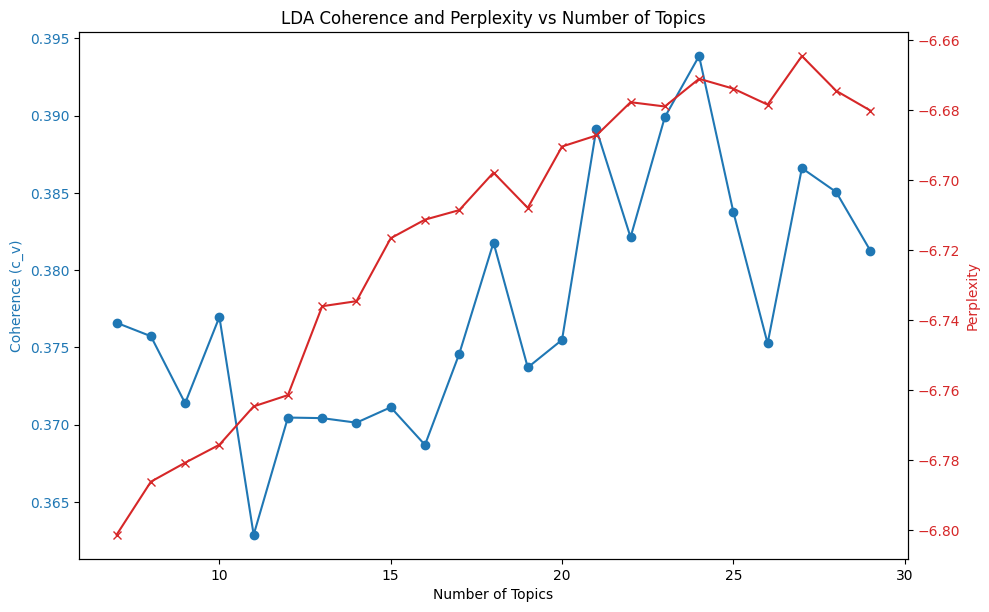

In [130]:
topic_range = range(7, 30, 1)

plot_topic_validation(topic_range=topic_range, text_list=bigram_list, corpus=bigram_corpus, dictionary=bigram_dict)

### 2. LDA Model (Gensim)

In [28]:
# Hyperparameters
num_topics = 24
passes = 10          # number of iterations over the corpus
random_state = 42    # reproducibility
alpha = 'auto'       # document-topic prior
eta = 'auto'         # topic-word prior

# Train LDA
lda = LdaModel(
    corpus=bigram_corpus,
    id2word=bigram_dict,
    num_topics=num_topics,
    passes=passes,
    random_state=random_state,
    alpha=alpha,
    eta=eta
)


#### Evaluate Output

##### Overall Model

In [ ]:
# coherence for overall model

coherence = CoherenceModel(
    model=lda,
    texts=bigram_list,
    dictionary=bigram_dict,
    coherence="c_v"
)

coherence_score = coherence.get_coherence()
coherence_score

0.39385091712113635

In [104]:
# perplexity 

perplexity = lda.log_perplexity(bigram_corpus)
perplexity

-6.632591409653365

In [29]:
# raw most common words

rows = []

for i, topic in lda.show_topics(num_topics=num_topics, num_words=20, formatted=False):
    words = [w for w, prob in topic]
    row = {"topic_id": i}
    for j, w in enumerate(words):
        row[f"word_{j+1}"] = w
    rows.append(row)

top_topic_words = pd.DataFrame(rows)
top_topic_words

,topic_id,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,...,word_11,word_12,word_13,word_14,word_15,word_16,word_17,word_18,word_19,word_20
0,0,mortgage,report,fund,housing,required,code,date,enforcement,general,...,federal,review,capital,including,state,national,insurance,information,rural,department
1,1,housing,state,property,local,community,government,unit,development,term,...,grant,general,amount,public,including,land,eligible,federal,assistance,mean
2,2,disaster,fund,assistance,housing,grantee,property,amount,requirement,development,...,grant,recovery,available,use,general,community,area,federal,activity,term
3,3,housing,homeless,program,state,homelessness,person,individual,assistance,mr,...,income,congress,including,grant,community,family,house,year,service,member
4,4,energy,housing,amount,development,efficiency,year,program,requirement,cost,...,standard,purpose,state,community,loan,taxpayer,use,cooperative,individual,system
5,5,property,housing,state,assistance,contract,tenant,covered,payment,condition,...,united,owner,based,standard,project,term,structure,law,physical,unit
6,6,project,program,grant,loan,local,eligible,state,federal,recreation,...,term,amount,area,community,facility,assistance,development,cost,including,secured
7,7,director,entity,housing,regulated,federal,enterprise,agency,mortgage,inserting,...,general,term,action,loan,period,contract,home,finance,agreement,date
8,8,assistance,housing,amount,available,rental,state,year,made,pursuant,...,requirement,unit,income,emergency,person,grant,homeless,family,eligible,provided
9,9,housing,grant,public,development,entity,eligible,program,community,term,...,organization,resident,state,project,federal,agency,transportation,income,deleted_deleted,low


In [30]:
rows = []

corpus_word_freq = np.array(list(lda.id2word.cfs.values()), dtype=float) # get the frequency of each word across the entire corpus
corpus_word_prob = corpus_word_freq / corpus_word_freq.sum() # calculate porportions 

for topic_id in range(num_topics):
    topic = lda.get_topic_terms(topic_id, topn=len(lda.id2word)) # get sorted list of all terms in the topic

    word_ids, topic_probs = zip(*topic) # unpack ids and probabilities
    topic_probs = np.array(topic_probs) # turn into np array

    # compute lift = P(word|topic) / P(word)
    lifts = topic_probs / corpus_word_prob[list(word_ids)]

    # top distinctive words
    top_idx = lifts.argsort()[::-1][:15]
    top_idx = lifts.argsort()[::-1][:15]

    for i in top_idx:
        rows.append({
            "topic": topic_id,
            "word": lda.id2word[word_ids[i]],
            "probability_in_topic": topic_probs[i],
            "lift": lifts[i]
        })

# convert to DataFrame
lift_df = pd.DataFrame(rows)

lift_df


,topic,word,probability_in_topic,lift
0,0,review,0.006273,4802.610560
1,0,status,0.002989,4576.212280
2,0,relevant,0.001668,2553.951535
3,0,oversight,0.001537,2353.773377
4,0,clause,0.002545,1948.236531
...,...,...,...,...
355,23,rehabilitation,0.001674,854.400340
356,23,code,0.005777,804.141741
357,23,respect,0.007508,766.400450
358,23,director,0.000488,746.771642


In [ ]:
def show_topic_words(topic_id):

    # Raw top words
    raw_words_row = top_topic_words[top_topic_words['topic_id'] == topic_id]
    raw_words = raw_words_row.iloc[0].drop('topic_id').tolist()
    
    print(f"Topic {topic_id} - Raw Top Words:")
    print(", ".join(raw_words))
    
    # Top lift words
    lift_words = lift_df[lift_df['topic'] == topic_id].sort_values('lift', ascending=False)['word'].tolist()
    
    print(f"\nTopic {topic_id} - Top Lift (Distinctive) Words:")
    print(", ".join(lift_words))
    print("\n")

In [35]:
for i in range(num_topics):
    show_topic_words(i)

Topic 0 - Raw Top Words:
mortgage, report, fund, housing, required, code, date, enforcement, general, requirement, federal, review, capital, including, state, national, insurance, information, rural, department

Topic 0 - Top Lift (Distinctive) Words:
review, status, relevant, oversight, clause, code, premium_surcharge, compliance, director, professional, clearinghouse, servicing, enforcement, streamlining, degree


Topic 1 - Raw Top Words:
housing, state, property, local, community, government, unit, development, term, program, grant, general, amount, public, including, land, eligible, federal, assistance, mean

Topic 1 - Top Lift (Distinctive) Words:
revitalization, historic, nib, supply, nia, nia_operating, review, transportation, regeneration, prevent, change, external_partner, relevant, research, operating_subsidiary


Topic 2 - Raw Top Words:
disaster, fund, assistance, housing, grantee, property, amount, requirement, development, state, grant, recovery, available, use, general, 

##### By Topic

In [108]:
# coherence for topics

coherence_topics = coherence.get_coherence_per_topic()

for topic_num, score in enumerate(coherence_topics):
    print(f"Topic {topic_num + 1}: {score:.4f}")

Topic 1: 0.2991
Topic 2: 0.3890
Topic 3: 0.3866
Topic 4: 0.4131
Topic 5: 0.2832
Topic 6: 0.4377
Topic 7: 0.3718
Topic 8: 0.3638
Topic 9: 0.3902
Topic 10: 0.4080
Topic 11: 0.4570
Topic 12: 0.3971
Topic 13: 0.3685
Topic 14: 0.3966
Topic 15: 0.4190
Topic 16: 0.5255
Topic 17: 0.3299
Topic 18: 0.5787
Topic 19: 0.3046
Topic 20: 0.4251
Topic 21: 0.4171
Topic 22: 0.4810
Topic 23: 0.2948
Topic 24: 0.3152


In [120]:
# get topic probabilities for documents
rows = []
for i, doc_bow in enumerate(bigram_corpus):
    topic_probs = lda.get_document_topics(doc_bow, minimum_probability=0)
    row = {f"topic_{topic}": prob for topic, prob in topic_probs}
    rows.append(row)

doc_topic_df = pd.DataFrame(rows) # turn into df
doc_topic_df.index = text_df["bill_id"].values # add back original doc_id

doc_topic_df.to_csv("../data/lda_output/bill_topic_probs.csv")

doc_topic_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23
110-hr1752,0.147512,0.000014,0.013023,0.000013,0.068225,0.000013,0.000012,0.000012,0.000016,0.000016,...,0.000932,0.007295,0.136063,0.000011,0.000012,0.000014,0.014907,0.000018,0.011307,0.012896
110-hr1999,0.000194,0.000220,0.000224,0.000208,0.000192,0.000210,0.000192,0.000181,0.000250,0.146145,...,0.000304,0.000177,0.000227,0.000171,0.000191,0.000221,0.000278,0.000285,0.000194,0.000208
110-s1386,0.131609,0.000013,0.000013,0.000012,0.000011,0.000012,0.000011,0.000010,0.016786,0.040274,...,0.006233,0.000010,0.000013,0.000010,0.214463,0.000013,0.024016,0.000016,0.000485,0.000012
110-hr1227,0.003575,0.000008,0.365646,0.000922,0.000007,0.000008,0.000007,0.000007,0.102188,0.027100,...,0.114316,0.000006,0.000008,0.000006,0.000007,0.064243,0.179143,0.141270,0.000007,0.000008
110-hr1515,0.000536,0.000609,0.000619,0.124232,0.000531,0.000579,0.000531,0.000500,0.000692,0.000674,...,0.000838,0.000488,0.601947,0.000471,0.000527,0.000611,0.000767,0.000788,0.000537,0.000575


In [109]:
# topics with highest probability
best_topic_df = pd.DataFrame(index=text_df["bill_id"].values)
best_topic_df["best_topic"] = doc_topic_df.idxmax(axis=1)

best_topic_df["best_topic_prob"] = doc_topic_df.max(axis=1)

best_topic_df

,best_topic,best_topic_prob
110-hr1752,topic_10,0.507338
110-hr1999,topic_13,0.848934
110-s1386,topic_10,0.556191
110-hr1227,topic_2,0.365706
110-hr1515,topic_16,0.601931
...,...,...
119-hr889,topic_14,0.785242
119-s965,topic_8,0.479654
119-hr5387,topic_14,0.302834
119-hr4457,topic_3,0.964693


In [132]:
best_topic_df["best_topic_prob"].describe()

count    1657.000000
mean        0.699601
std         0.230690
min         0.230263
25%         0.502124
50%         0.675410
75%         0.950927
max         0.999889
Name: best_topic_prob, dtype: float64

In [111]:
# which topics are most and least common?
# could also look at the distribution of scores for each topic
best_topic_df["best_topic"].value_counts()

best_topic
topic_10    240
topic_14    147
topic_13    133
topic_21    132
topic_11    111
topic_8     106
topic_16     97
topic_20     71
topic_3      64
topic_12     55
topic_2      50
topic_5      49
topic_9      46
topic_4      45
topic_1      45
topic_19     43
topic_18     41
topic_15     40
topic_0      39
topic_23     35
topic_17     20
topic_6      19
topic_7      17
topic_22     12
Name: count, dtype: int64

In [119]:
# distrinctiveness

topics = lda.get_topics()

distinctiveness_scores = []

for i in range(len(topics)):
    divergences = []
    for j in range (len(topics)):
        if i != j:
            div = jensenshannon(topics[i], topics[j])
            divergences.append(div)
    avg_div = np.mean(divergences)
    distinctiveness_scores.append(avg_div)

for topic_num, score in enumerate(distinctiveness_scores):
    print(f"Topic {topic_num + 1}: {score:.4f}")

Topic 1: 0.5020
Topic 2: 0.4744
Topic 3: 0.4808
Topic 4: 0.5143
Topic 5: 0.4973
Topic 6: 0.5242
Topic 7: 0.5254
Topic 8: 0.5065
Topic 9: 0.4809
Topic 10: 0.4782
Topic 11: 0.4991
Topic 12: 0.4837
Topic 13: 0.5049
Topic 14: 0.4781
Topic 15: 0.4861
Topic 16: 0.5550
Topic 17: 0.5044
Topic 18: 0.5966
Topic 19: 0.5267
Topic 20: 0.4885
Topic 21: 0.4610
Topic 22: 0.4864
Topic 23: 0.4913
Topic 24: 0.4786


##### Looking at bills

In [52]:
def look_at_bill(bill_id):

    bill_id = bill_id.replace("-","")
    congress = bill_id[:3]

    possible_bills = os.listdir(f"../data/congress_api_data_10_21/{congress}/text")
    bill_file = [bill for bill in possible_bills if bill_id in bill][0]

    file = f"../data/congress_api_data_10_21/{congress}/text/{bill_file}"

    try:
        with open(file, 'r', encoding='utf-8') as f:
            html_content = f.read()
        print(html_content)
    except FileNotFoundError:
        print(f"Error: The file '{file}' was not found.")   

def look_at_bill_with_topic(topic):

    all_bills = best_topic_df[best_topic_df["best_topic"]==topic].index

    random_bill_id = all_bills.to_series().sample(1).iloc[0]

    look_at_bill(random_bill_id)


In [99]:
look_at_bill_with_topic("topic_2")

<html><body><pre>
[Congressional Bills 118th Congress]
[From the U.S. Government Publishing Office]
[S. 3692 Introduced in Senate (IS)]

&lt;DOC&gt;






118th CONGRESS
  2d Session
                                S. 3692

To prohibit the use of algorithmic systems to artificially inflate the 
  price or reduce the supply of leased or rented residential dwelling 
                      units in the United States.


_______________________________________________________________________


                   IN THE SENATE OF THE UNITED STATES

                            January 30, 2024

  Mr. Wyden (for himself, Mr. Welch, Ms. Klobuchar, Mr. Sanders, Mr. 
  Blumenthal, Ms. Hirono, Ms. Butler, and Mr. Merkley) introduced the 
 following bill; which was read twice and referred to the Committee on 
                             the Judiciary

_______________________________________________________________________

                                 A BILL


 
To prohibit the use of algorithm

### 3. Visualize

In [100]:
vis = gensimvis.prepare(lda, bigram_corpus, bigram_dict)

In [101]:
pyLDAvis.display(vis)
